In this article we will particulary talk about the concepts related to finetuning and their applications in the field of deep learning.
The entire content can be divided into the following sections:
1. Introduction to Finetuning
2. Types of finetuning
3. Model Quantization
4. PEFT training methods
5. Adapters 
6. LORA 
7. QLORA
8. Code Walkthrough

##### LIFE CYCLE OF LLM #####

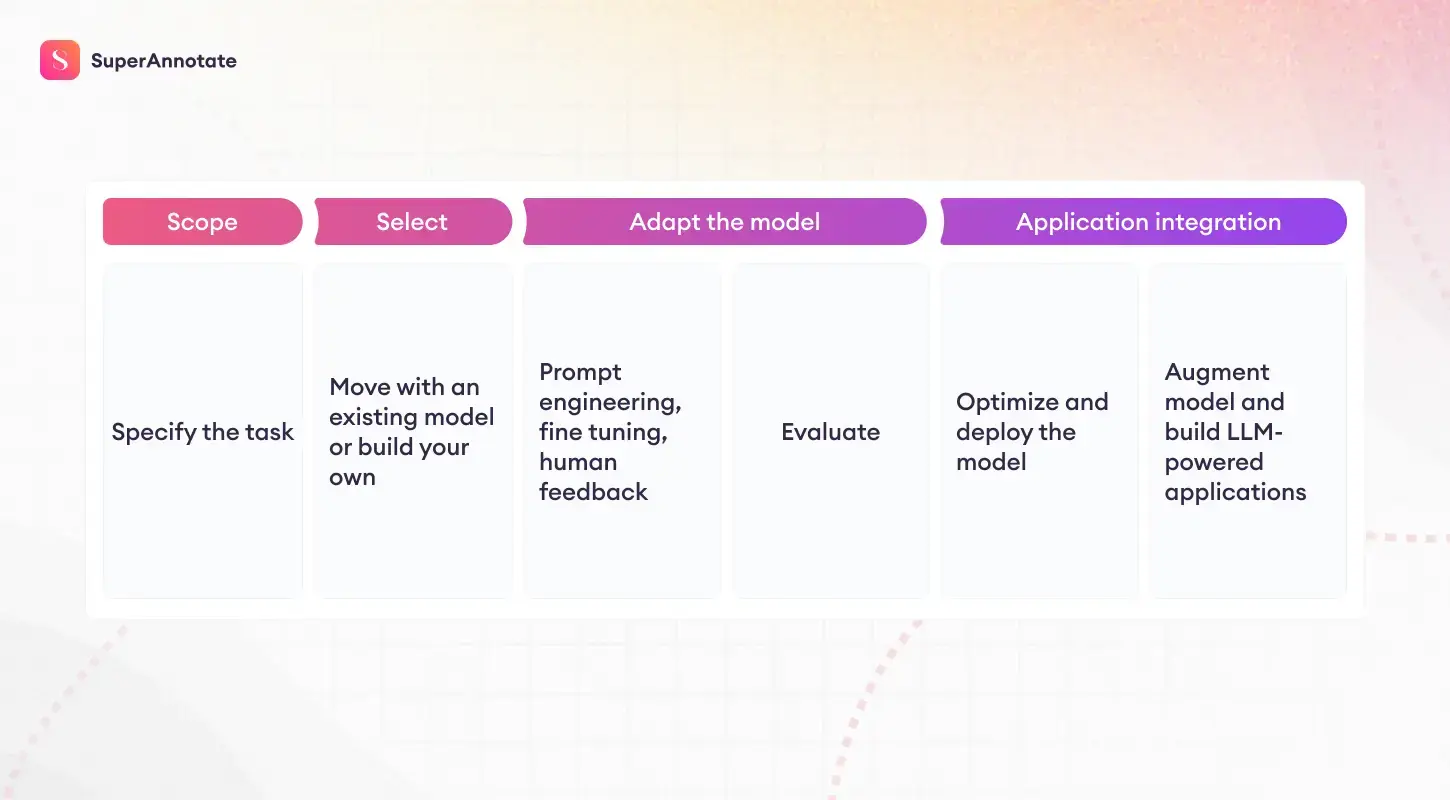

Why we need finetuning?

Fine-tuning large language models (LLMs) is essential because it allows these pre-trained models, which have learned general language representations from vast corpora, to adapt to specific downstream tasks and datasets.
fine-tuning involves the optimization of a model's parameters through gradient descent on a task-specific dataset, adjusting the weights of the neural network to minimize a predefined loss function. This process enhances the model's capability to capture domain-specific semantics, patterns, and relationships, thus improving its performance on tasks such as classification, generation, or question answering. By leveraging the transfer learning paradigm, fine-tuning effectively reduces the need for extensive labeled data while achieving higher accuracy, faster convergence, and better generalization to the target task.

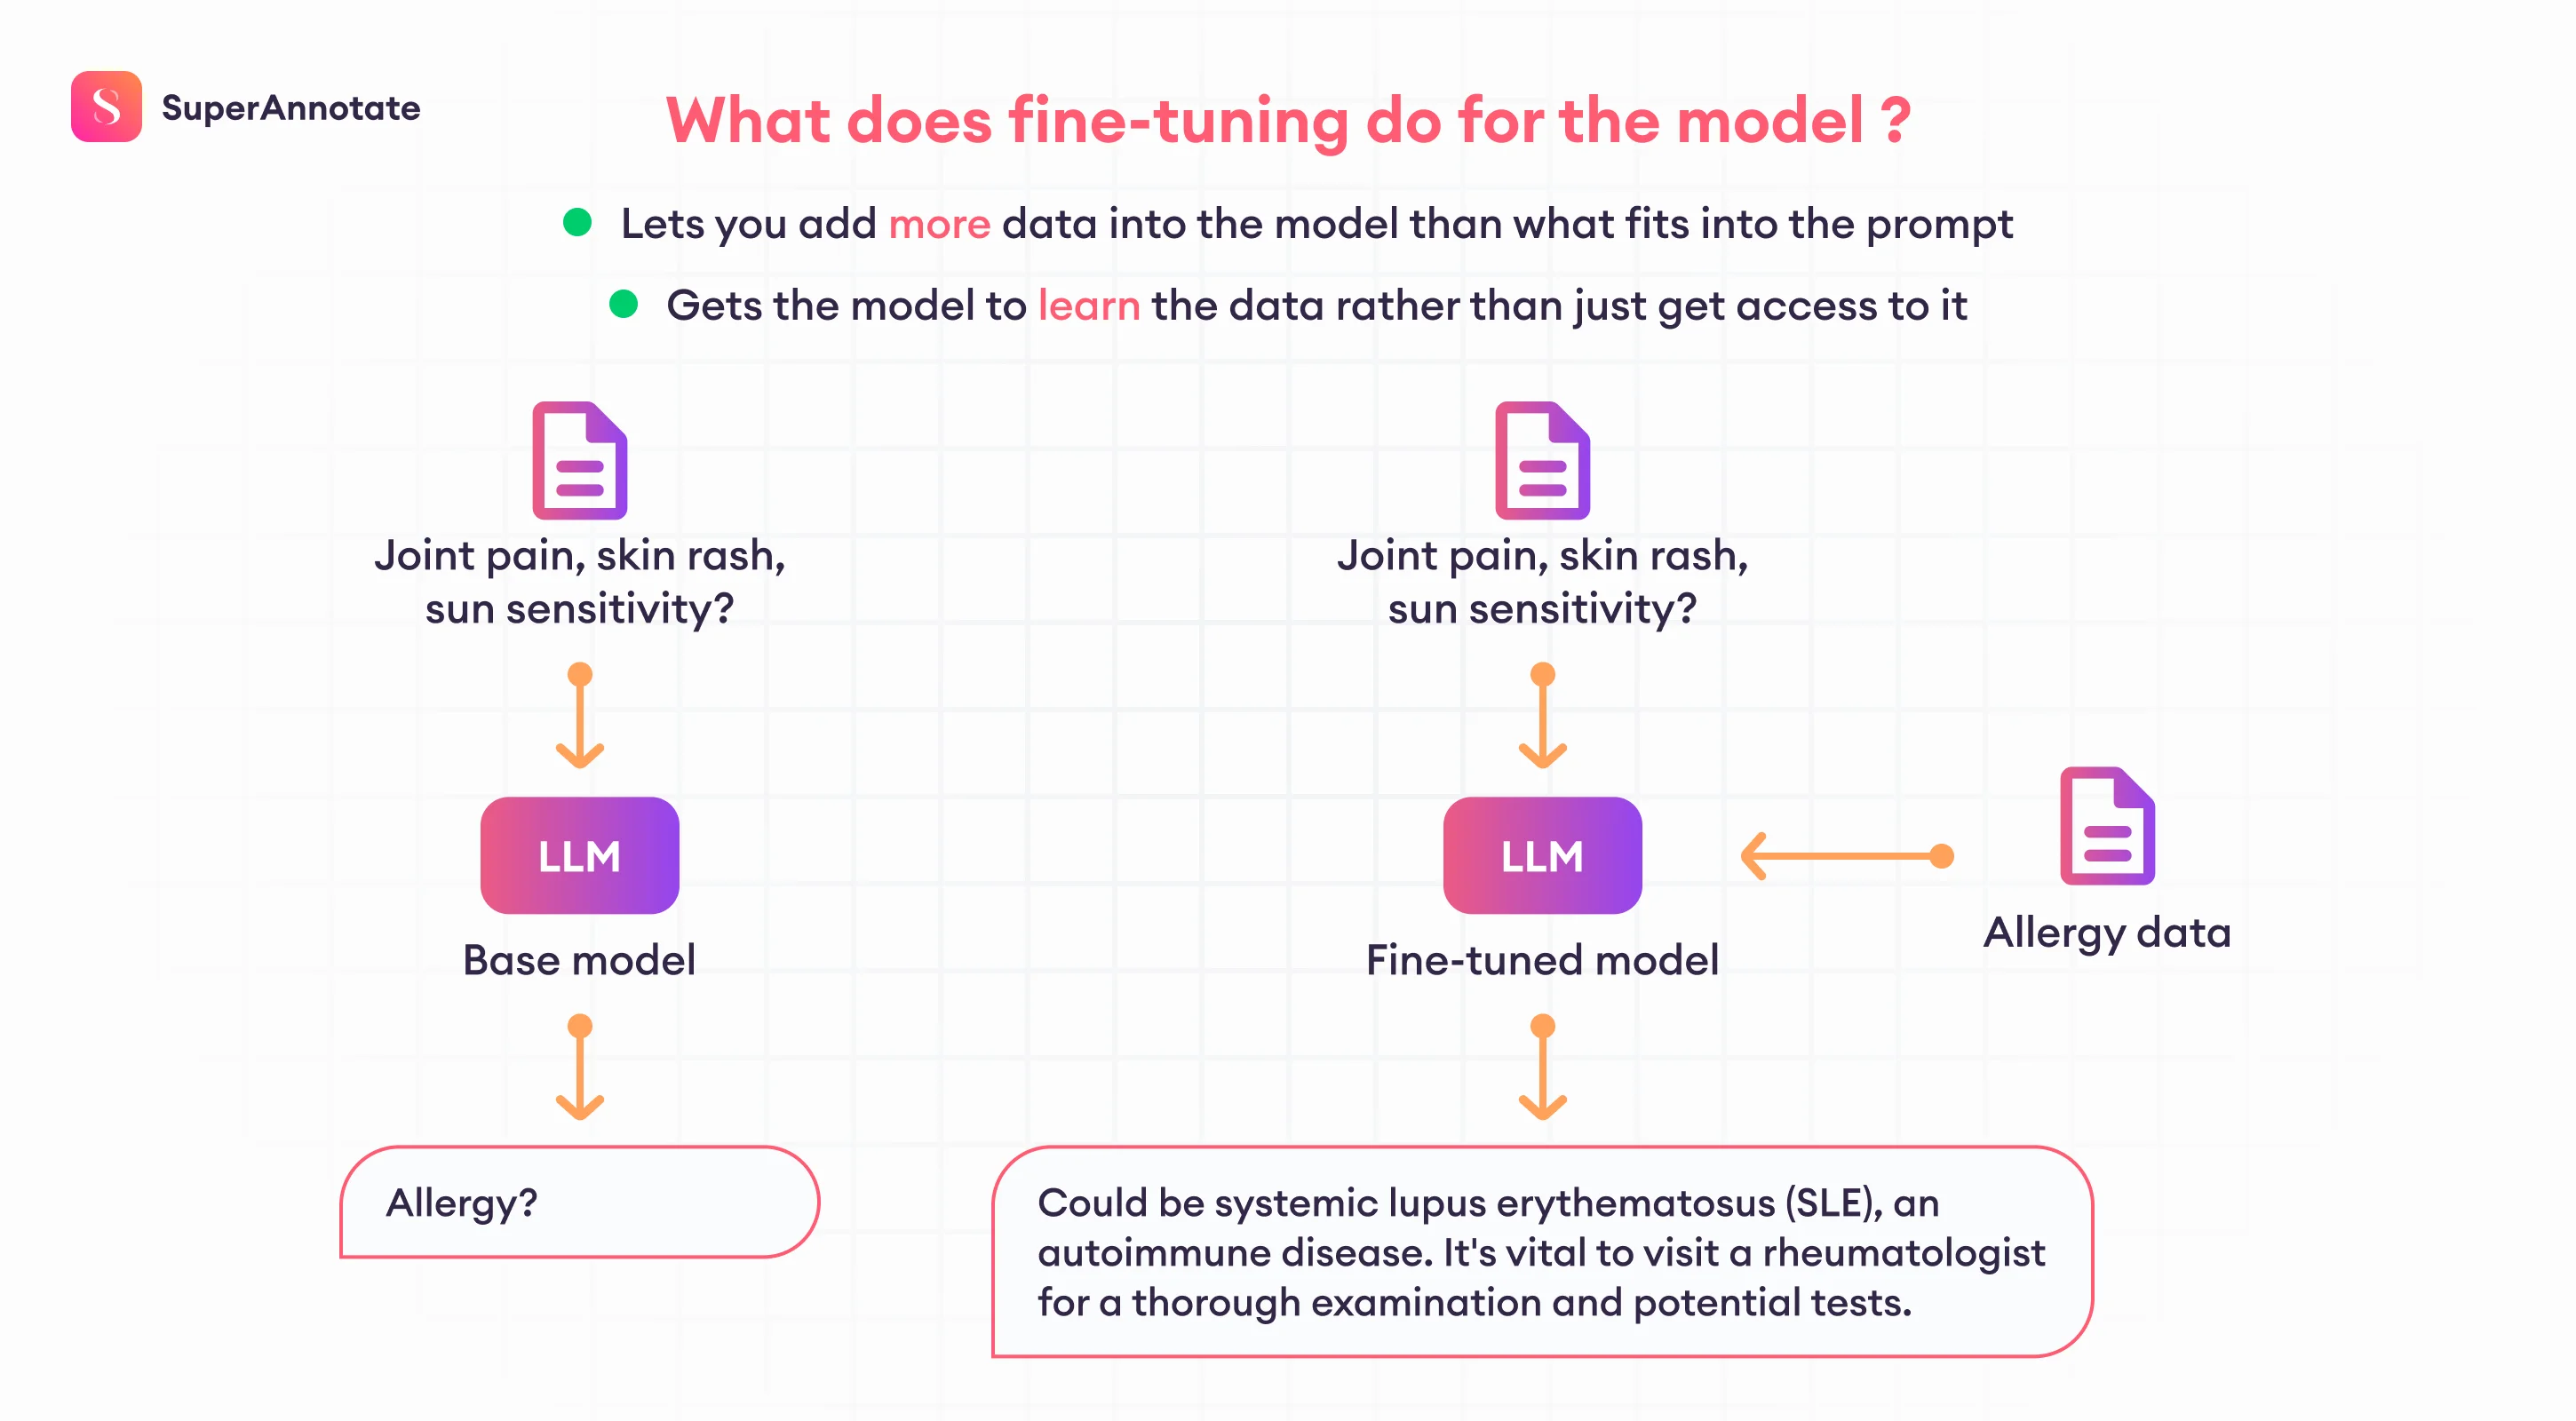

# Types of finetuning

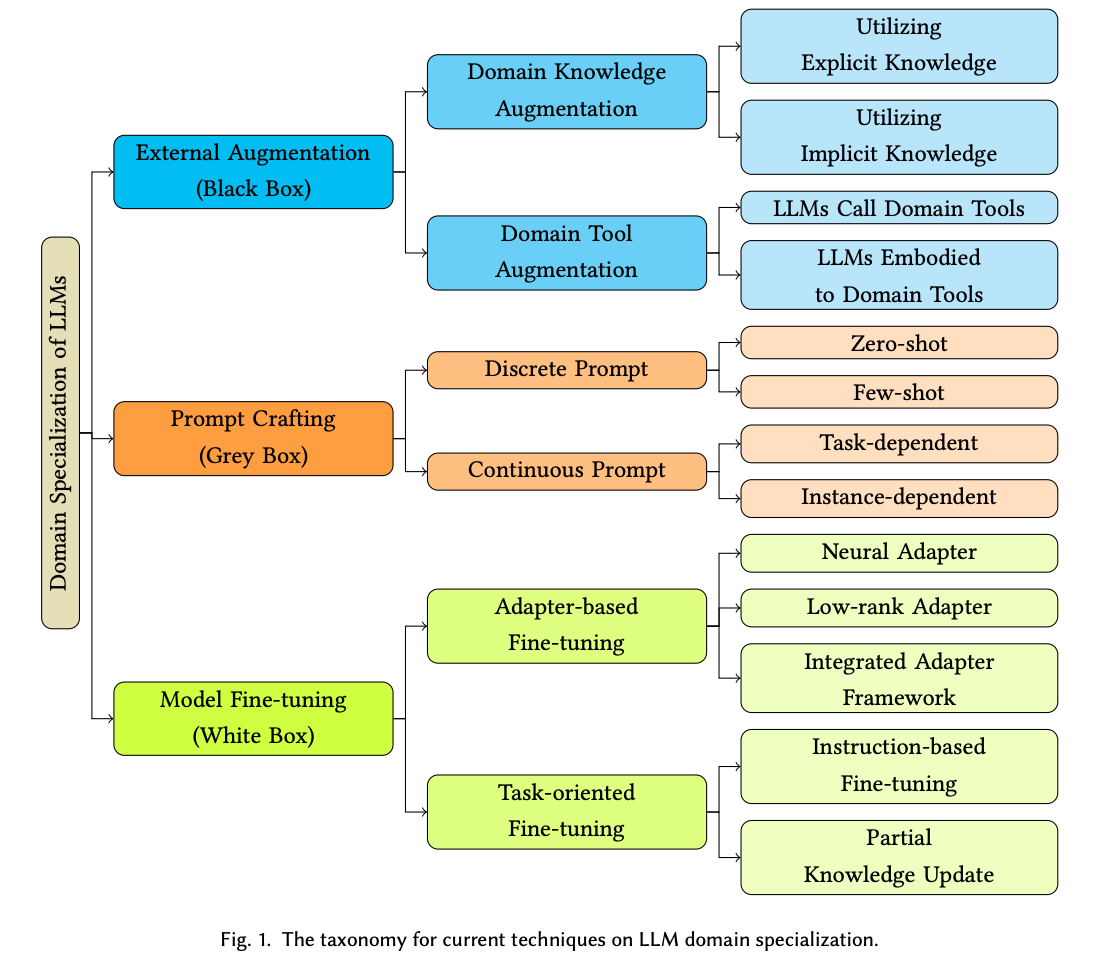

# Finetuning Methodologies for LLMs

## 1. Full Model Finetuning
This method involves updating all the weights of the model using a task-specific dataset. It requires a large dataset and high computational resources, as it retrains the entire model.

## 2. Parameter Efficient Finetuning (PEFT)
Instead of fine-tuning the entire model, only a subset of parameters is updated. This reduces computational cost and helps when the dataset is smaller. One of the popular approaches is LoRA (Low-Rank Adaptation), which injects learnable matrices into the model’s architecture and fine-tunes only those.

**Example**: Using LoRA for fine-tuning and Qlora for quantization can help in reducing the computational cost and memory footprint.

## 3. Prompt Tuning
This method does not modify the model's internal parameters. Instead, it learns task-specific prompts. It’s useful when you don’t have access to the underlying model weights or when computational resources are limited.

## 4. Adapter-based Finetuning
This technique inserts adapter modules into the model and only trains those adapters while freezing the main model weights. Adapters can be easily reused for different tasks without affecting the underlying model.

## 5. Instruction-based Finetuning (RLHF)
This involves Reinforcement Learning with Human Feedback (RLHF). It’s more complex as it involves a reward model to guide the learning process based on human preferences, such as adapting the GPT model to ChatGPT.


# Finetuning Methodologies for LLMs

## 1. Full Model Finetuning
### Usage:
- Used when a large, task-specific dataset is available.
- Updates all parameters of the pre-trained model.

### Pros:
- High accuracy for specific tasks.
- Captures nuanced patterns in the data.

### Cons:
- Requires significant computational resources.
- Risk of overfitting on small datasets.

---

## 2. Parameter Efficient Finetuning (PEFT)
### Usage:
- Used when resources are limited or for small datasets.
- Updates only a subset of parameters (e.g., LoRA, adapters).

### Pros:
- Reduced computational requirements.
- Allows for quick adaptations to different tasks.

### Cons:
- May not achieve the same level of performance as full finetuning.
- Potentially less flexible for complex tasks.

---

## 3. Prompt Tuning
### Usage:
- Useful when only a small amount of labeled data is available.
- Adapts the model behavior without modifying its weights.

### Pros:
- Efficient for low-resource scenarios.
- Easy to implement and requires minimal changes.

### Cons:
- Effectiveness highly depends on the quality of prompts.
- May not generalize well across tasks.

---

## 4. Adapter-based Finetuning
### Usage:
- Suitable for multi-task scenarios or when dealing with multiple labels.
- Inserts adapter modules and only trains those.

### Pros:
- Efficient use of model parameters for different tasks.
- Easy to switch between tasks without retraining the entire model.

### Cons:
- Might require additional tuning to optimize adapter performance.
- Complexity in model architecture may increase.

---

## 5. Instruction-based Finetuning (RLHF)
### Usage:
- Used to incorporate human preferences into model training.
- Applies reinforcement learning techniques.

### Pros:
- Improves model behavior based on human feedback.
- Can enhance user satisfaction in interactive applications.

### Cons:
- Complex to implement and requires significant resources.
- Dependence on quality and representativeness of human feedback.

---



For this article we will focus only only SFT using PEFT methodologies

# Quantization in Machine Learning

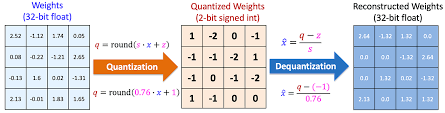

## Definition

**Quantization** reduces the computational and memory costs of inference by representing weights and activations with low-precision data types (e.g., 8-bit integers, int8) instead of 32-bit floating-point (float32).

## Theoretical Foundations

### Data Types

Common lower-precision data types:
- **float16**: 16-bit floating-point
- **bfloat16**: 16-bit optimized for deep learning
- **int8**: 8-bit integer

### Accumulation Data Types

Defines the result type for operations. For example, summing two int8 values requires a higher precision (e.g., int32) to avoid overflow.

## Quantization Methods

### Float32 to Float16

- **Conversion**: Directly transitions from float32 to float16, considering:
  - Hardware support for float16
  - Sensitivity of operations to lower precision (e.g., \(\epsilon\) in LayerNorm).

### Float32 to Int8

The affine quantization scheme is used:
\[ 
x = S \cdot (x_q - Z) 
\]
Where:
- \( x_q \): Quantized int8 value
- \( S \): Scale factor
- \( Z \): Zero-point

The quantized value \( x_q \) is calculated as:
\[ 
x_q = \text{clip}\left(\text{round}\left(\frac{x}{S} + Z\right), \text{round}\left(\frac{a}{S} + Z\right), \text{round}\left(\frac{b}{S} + Z\right)\right) 
\]

### Symmetric vs. Affine Quantization

- **Affine Quantization**: General mapping from \([a, b]\) to int8.
- **Symmetric Quantization**: Maps \([-a, a]\) to \([-127, 127]\) (setting \(Z = 0\)).

### Per-Tensor vs. Per-Channel Quantization

- **Per-Tensor**: One \((S, Z)\) pair for the entire tensor.
- **Per-Channel**: Separate \((S, Z)\) for each channel, enhancing accuracy at the cost of increased memory.

## Calibration

Determining the float32 range \([a, b]\) is crucial for effective quantization:

### Methods

1. **Post-Training Dynamic Quantization**: Computes ranges at inference time.
2. **Post-Training Static Quantization**: Uses representative data for range determination.
3. **Quantization Aware Training (QAT)**: Simulates quantization effects during training with "fake quantize" operations.

### Calibration Techniques

- **Min-Max**: \([ \text{min}, \text{max} ]\) based on observed values.
- **Moving Average Min-Max**: Stabilizes through averages over time.
- **Histogram**: Records value distributions and computes ranges using:
  - **Entropy**: Minimizes quantization error.
  - **Mean Square Error**: Reduces mean square error.
  - **Percentile**: Targets a specified percentage of observed values.

## Conclusion

Quantization optimizes machine learning models for deployment in resource-constrained environments. Understanding the mathematical frameworks and methods involved in quantization is essential for maximizing efficiency while preserving accuracy.

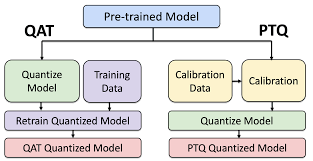

# PEFT

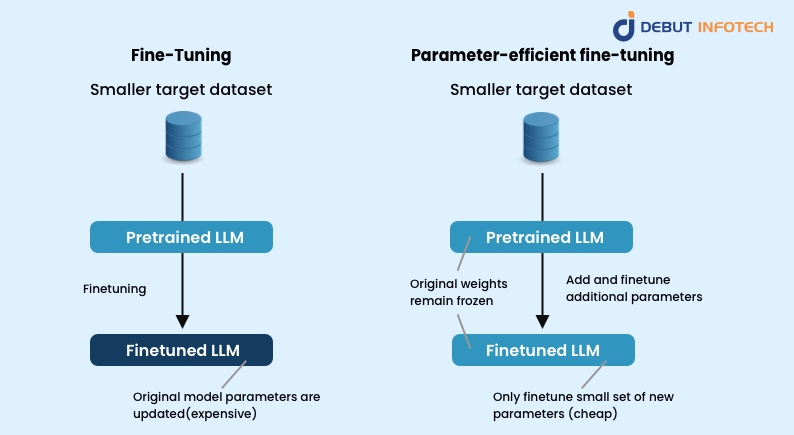

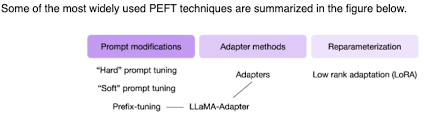

Parameter Efficient Fine-Tuning (PEFT) enables effective adaptation of large language models (LLMs) with minimal computational resources. By updating only a small subset of parameters, PEFT reduces memory usage and training time while maintaining performance comparable to traditional fine-tuning.

Key PEFT Approaches
1. LoRA (Low-Rank Adaptation)
Mechanism: Introduces low-rank matrices into existing layers, allowing fine-tuning of these additional parameters.
Benefits: Reduces the number of parameters updated, resulting in lower computational costs.
Example: Applying LoRA in attention layers for tasks like sentiment analysis.
2. Adapters
Mechanism: Inserts small modules between model layers, training only these while freezing the original weights.
Benefits: Facilitates quick task switching and multi-task learning without altering the base model.
Example: Using language-specific adapters in a multilingual model.
3. Prompt Tuning
Mechanism: Optimizes task-specific prompts without modifying model parameters.
Benefits: Requires minimal data and resources, leveraging the pre-trained model’s capabilities.
Example: Crafting prompts like "Summarize the text" for targeted outputs.
Advantages of PEFT
Resource Efficiency: Significantly lowers computational and memory requirements.
Faster Convergence: Reduces training time compared to full model fine-tuning.
Modularity: Allows reuse of adapters across different tasks.
High Performance: Maintains competitive accuracy with fewer parameters updated.

# Adapter-Based Fine-Tuning (PEFT)

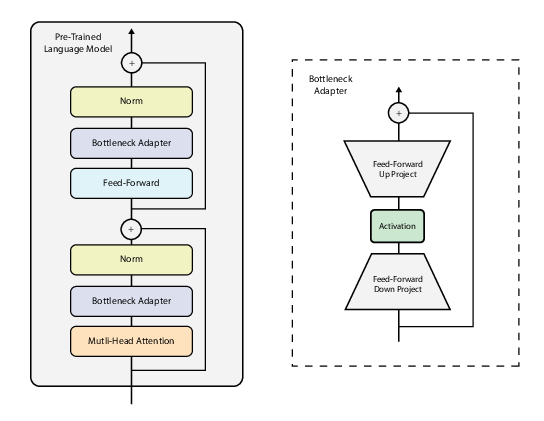

## Overview

Adapter-based fine-tuning is a Parameter Efficient Fine-Tuning (PEFT) approach that introduces lightweight modules called adapters into pre-trained models. These adapters are trained while keeping the original model weights frozen, allowing for efficient adaptation to various tasks without requiring extensive computational resources.

## Mechanism

1. **Insertion**: Adapters are inserted between the layers of a pre-trained model, typically Transformer-based architectures.
2. **Training**: Only the parameters of the adapters are updated during training, while the main model parameters remain unchanged.
3. **Modularity**: Different adapters can be trained for various tasks and swapped easily, enabling quick transitions between tasks.

### Mathematical Representation

Given a model layer \(f\), the output with an adapter \(A\) can be expressed as:

\[
y = f(x) + A(x)
\]

Where:
- \(y\) is the output.
- \(x\) is the input.
- \(A(x)\) represents the output from the adapter.

## Pros

- **Efficiency**: Significantly reduces the number of parameters that need to be trained, lowering memory and computational costs.
- **Task Modularity**: Enables the use of multiple adapters for different tasks, facilitating quick adaptation without retraining the entire model.
- **Preservation of Knowledge**: Maintains the integrity of the pre-trained model, reducing the risk of catastrophic forgetting.
- **Faster Training**: Requires less time to train compared to full model fine-tuning.

## Cons

- **Limited Capacity**: Adapters may not capture all the intricacies of a task as effectively as full fine-tuning might.
- **Overhead**: While lightweight, the introduction of adapters increases the model complexity slightly.
- **Task-Specific**: Adapters are task-dependent; each task may require a distinct adapter, leading to management overhead.

## Conclusion

Adapter-based fine-tuning is a powerful and efficient method for adapting large pre-trained models to specific tasks. While it offers significant advantages in terms of resource efficiency and flexibility, careful consideration is needed to ensure that the limitations of adapters do not impact task performance.


# LORA

### Low-Rank Adaptation (LoRA): Overview and Mathematical Foundation

**Concept:**
Low-Rank Adaptation (LoRA) is a Parameter-Efficient Fine-Tuning (PEFT) technique designed to optimize the fine-tuning of large language models by leveraging the concept of low-rank matrix approximations. It assumes that the changes in weights during adaptation can be efficiently captured using low-rank matrices, which reduces both computational complexity and resource requirements.

**Mathematical Foundation:**
- **Weight Change Representation:** LoRA posits that the change in weights, \( \Delta W \), during fine-tuning can be expressed as:
  \[
  \Delta W = BA
  \]
  where \( B \in \mathbb{R}^{d \times r} \) and \( A \in \mathbb{R}^{r \times m} \), with \( r \ll \min(d, m) \). Here, \( d \) is the dimension of the original weight matrix, and \( m \) is the output dimension.

- **Rank-Deficient Matrix:** The matrix \( \Delta W \) is considered rank-deficient, allowing it to be represented efficiently through the low-rank matrices \( B \) and \( A \).

**Training Mechanism:**
1. **Frozen Pre-trained Weights:** Let \( W^* \) be the frozen pre-trained weight matrix. The adapted output is given by:
   \[
   h = W^*x + BAx
   \]
   where \( x \) is the input.

2. **Optimization:** Only the matrices \( B \) and \( A \) are optimized during training, significantly reducing the number of trainable parameters and computational requirements.

**Benefits:**
- **Time & Memory Efficiency:** LoRA reduces VRAM usage significantly (e.g., from 1.2TB to 350GB for GPT-3) and cuts checkpoint size from 350GB to 35MB.
- **No Inference Latency:** Unlike adapter-based methods, there is no additional latency during inference, as the learned matrices are simply added to the pre-trained weights.
- **Easy Task Switching:** Facilitates quick transitions between tasks, requiring minimal changes to the weights.

**Performance:**
LoRA achieves performance levels comparable to or even exceeding full fine-tuning, despite using a smaller number of parameters.

### Summary:
LoRA enhances the fine-tuning process of large models by representing weight changes with low-rank approximations. This method is efficient in terms of time, memory, and storage, enabling high performance while minimizing resource use.

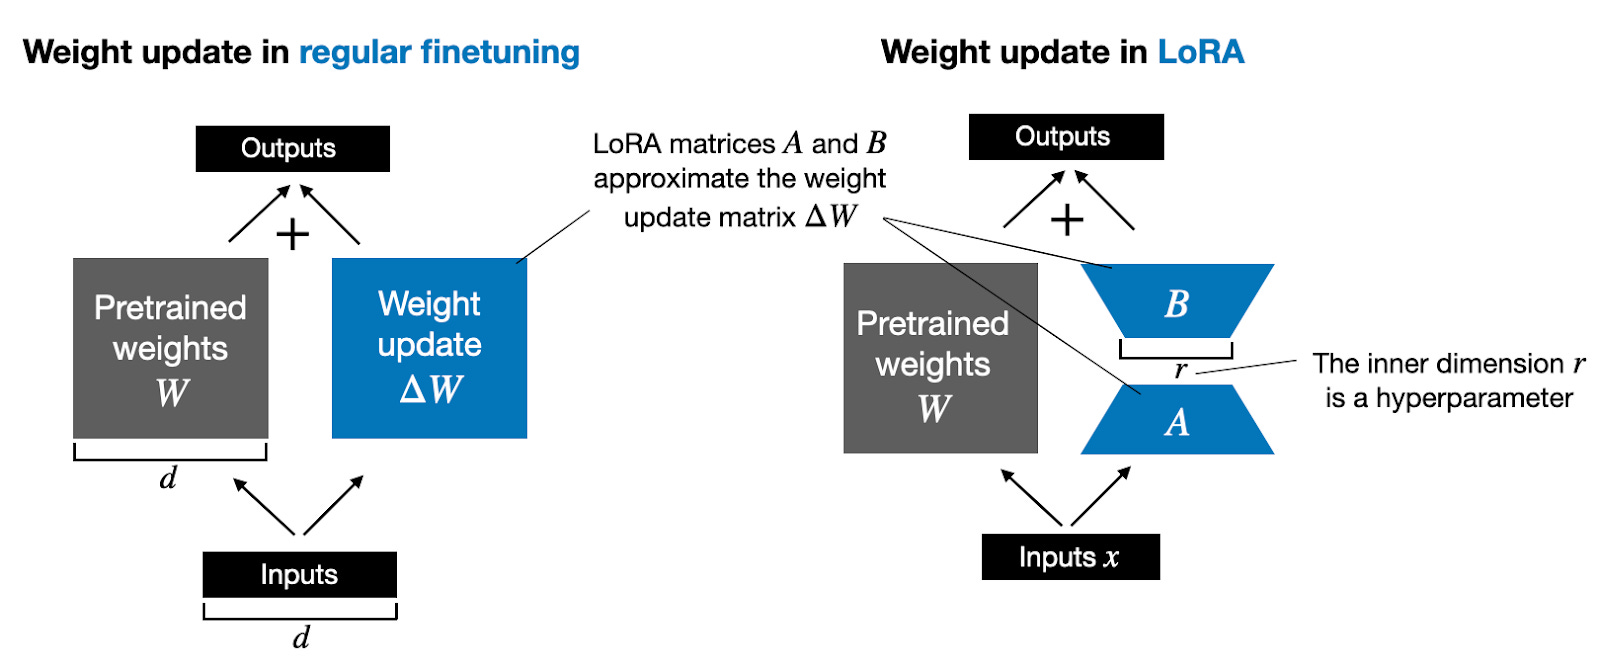

# Q-LORA
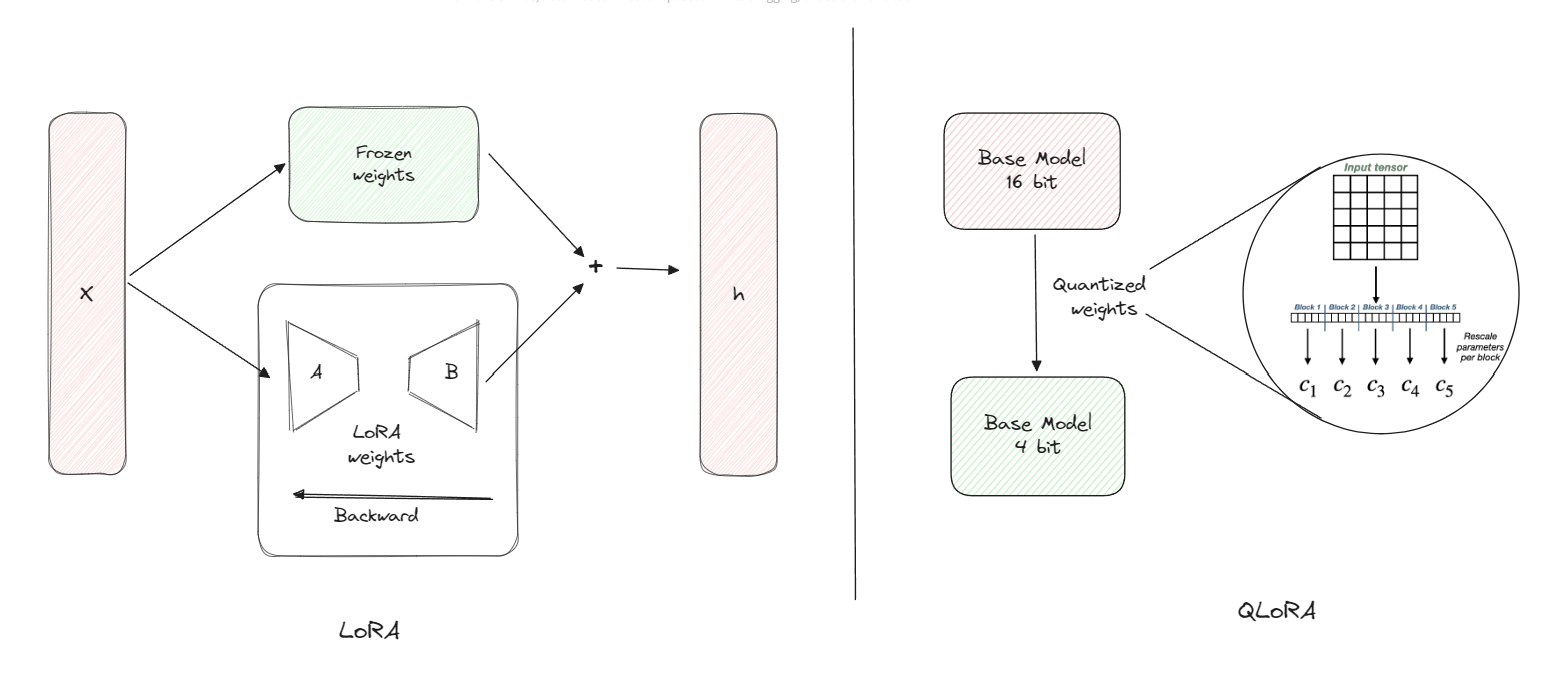


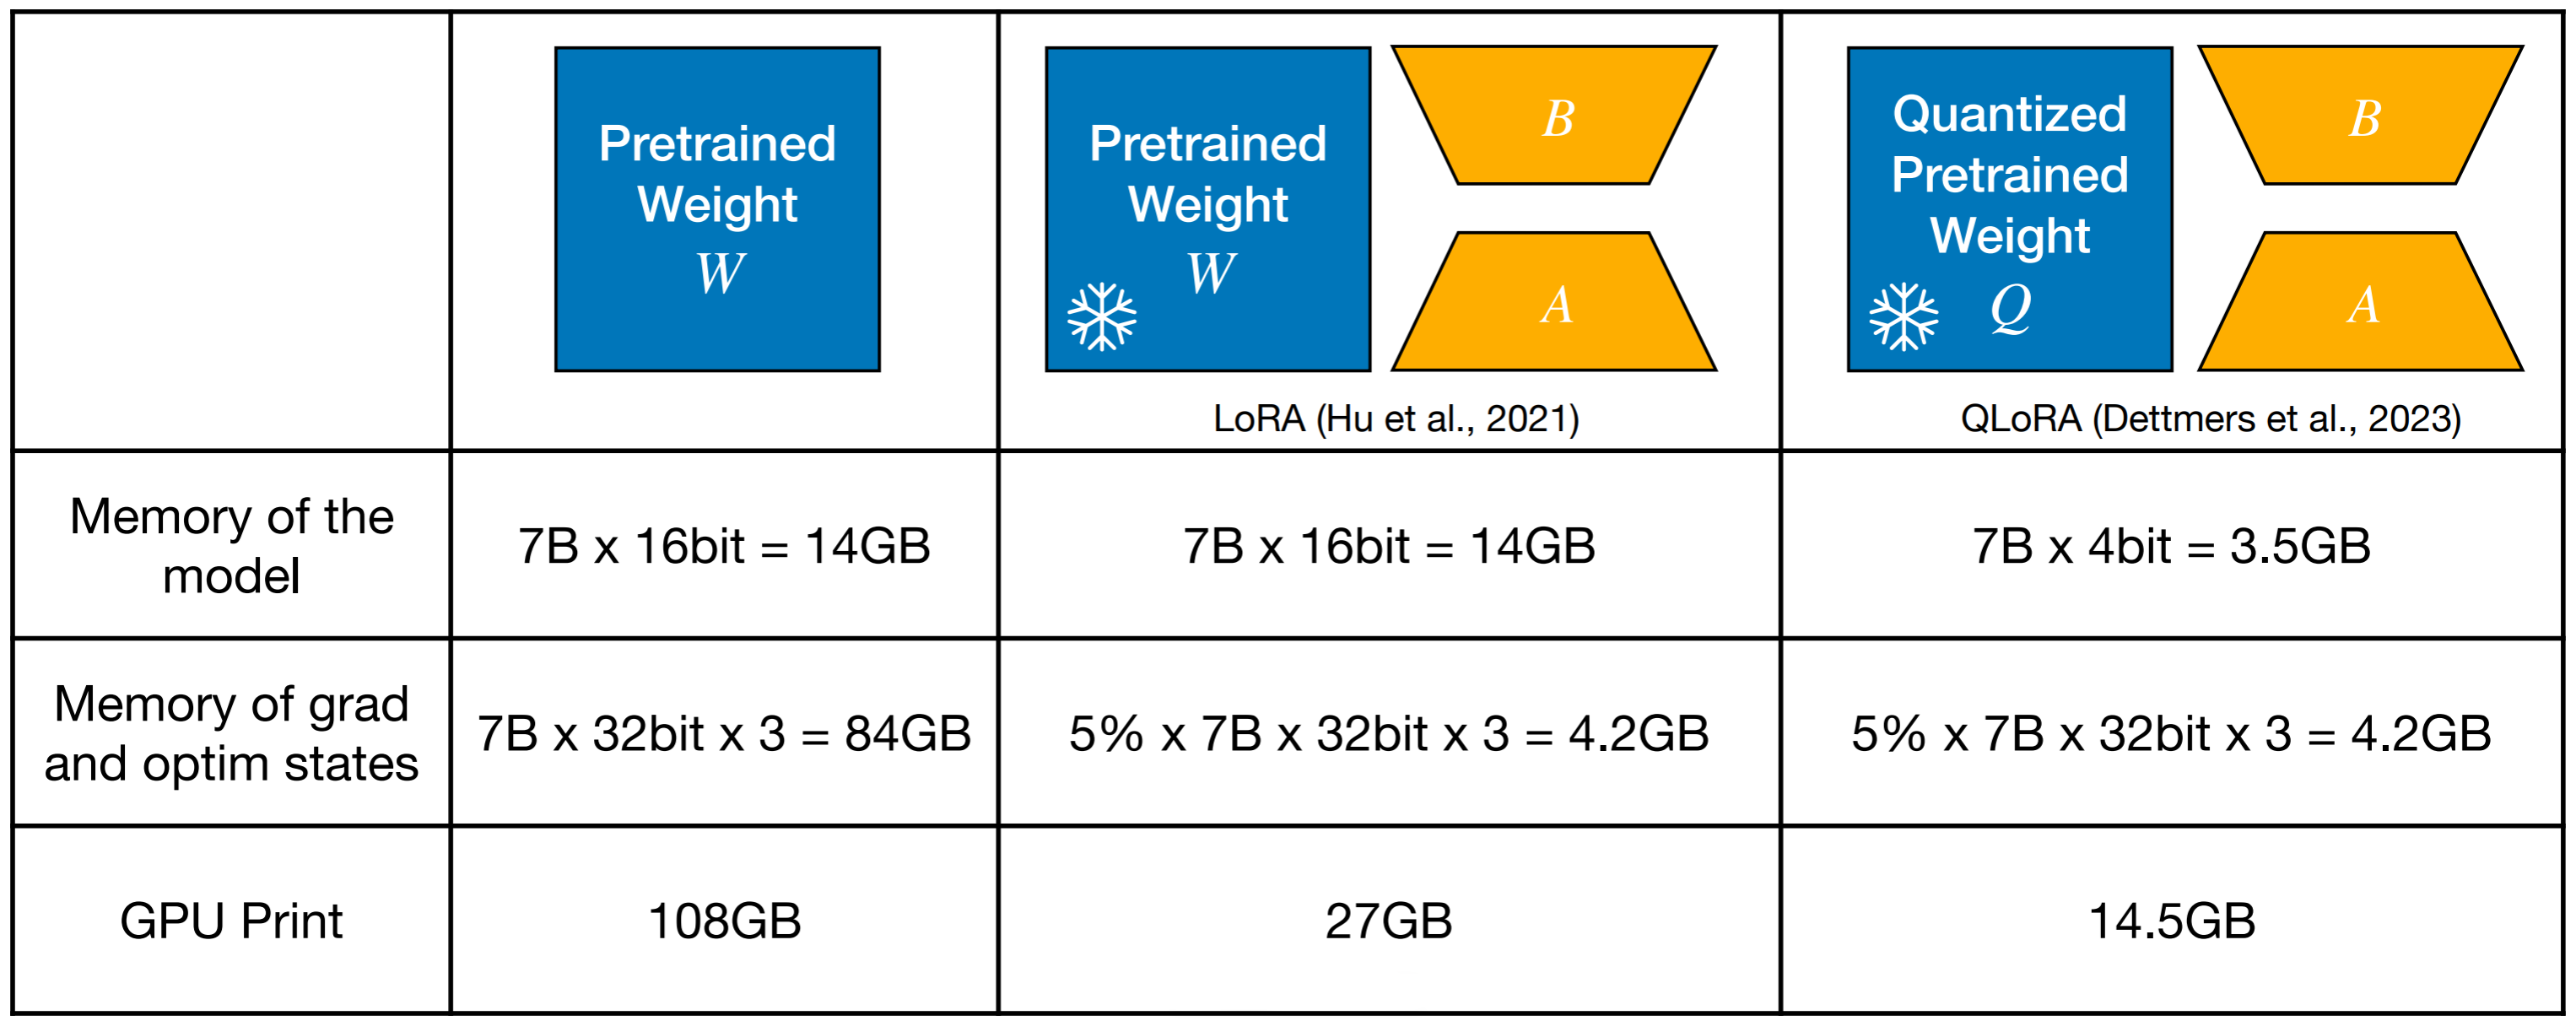